# Differential Phase Contrast Tutorial 00

This notebook uses the abtem-legacy package to simulate the strontium titanate dataset we'll use in the differential phase contrast tutorial series.

### Downloads
This tutorial uses the following files:
- [SrTiO3.cif](https://drive.google.com/file/d/1bJHrgEp-Tzg8xh4irDtXuIjLtHGLn7ZO/view?usp=drive_link)

### Acknowledgements

This tutorial was created by the py4DSTEM `phase_contrast` team:
- Georgios Varnavides (gvarnavides@berkeley.edu)
- Stephanie Ribet (sribet@lbl.gov)
- Colin Ophus (clophus@lbl.gov)

Last updated: 2024 May 6

In [1]:
import numpy as np
import py4DSTEM
import abtem
import ase

from emdfile import tqdmnd
from scipy.ndimage import rotate
import matplotlib.pyplot as plt

print(abtem.__version__)

1.0.0beta34


### Atomic Model

First, we import the strontium titanate (STO) unit cell and create the atomic simulation environment (ASE) Atoms object.

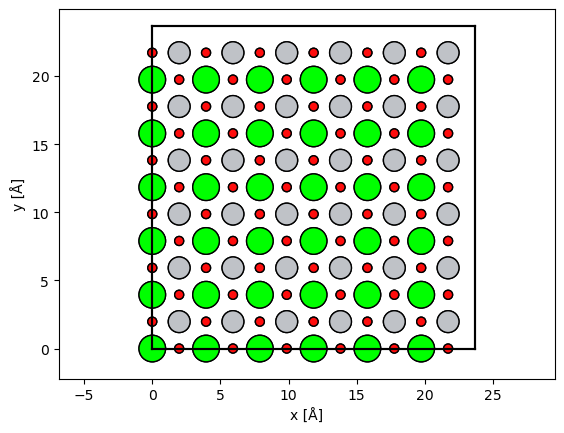

In [2]:
STO_atoms = ase.io.read("data/SrTiO3.cif")*(6,6,2)
abtem.show_atoms(STO_atoms);

### Potential and Probe

Next, we build the multi-sliced potential object, and a 20mrad in-focus probe.

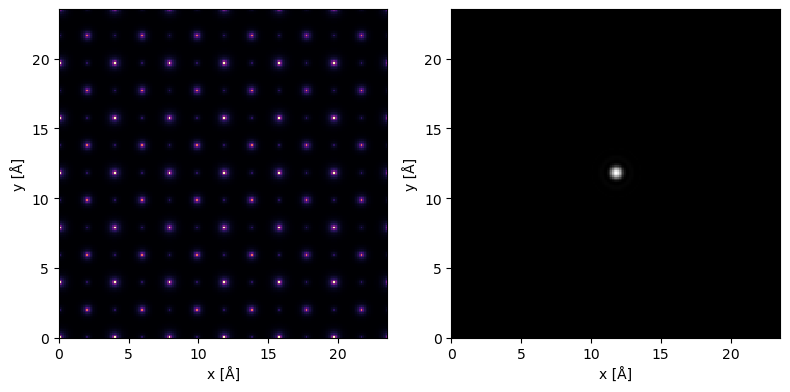

In [3]:
potential = abtem.Potential(
    STO_atoms,
    gpts=(192,192),
    device="gpu",
    projection="infinite",
    parametrization="kirkland",
)

probe = abtem.Probe(energy=200e3,semiangle_cutoff=20,device="gpu")
probe.match_grid(potential)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))
    
potential.project().show(
    ax=ax1,
    cmap='magma',
)

probe.show(ax =ax2);

fig.tight_layout()

### 4D-STEM Simulation

Next, we define a pixelated detector and raster scan and perform the simulation.  
_Note:_ We specify `max_angle=None` and the default `resample` to obtain a 4D-dataset with the same dimensions as the potential (which we will later crop/bin)

In [4]:
pixelated_detector = abtem.PixelatedDetector(max_angle=None)
gridscan = abtem.GridScan(
    (0,0), 
    np.diag(STO_atoms.cell)[:2]/6,
    gpts=(32,32),
)

measurement=probe.scan(gridscan,pixelated_detector,potential,pbar=True)

Potential:   0%|          | 0/16 [00:00<?, ?it/s]

Scan:   0%|          | 0/1024 [00:00<?, ?it/s]

We crop the dataset,specify common experimental artifacts, such as rotation and Poisson shot noise, and visualize the mean diffraction pattern.

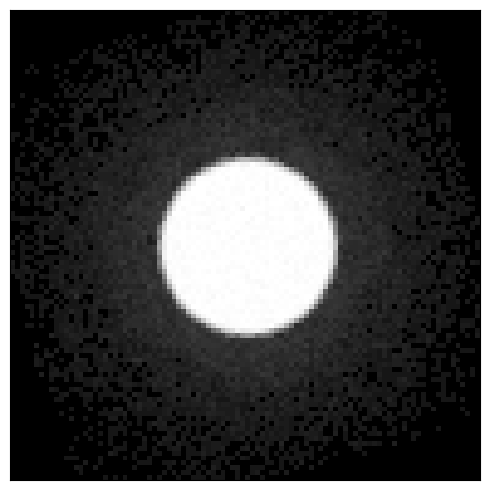

In [5]:
# crop
crop_x = crop_y = (192-96)//2
array = measurement[:,:,crop_x:-crop_x,crop_y:-crop_y].array

# rotate
array = rotate(array,15,reshape=False,order=1,axes=(-2,-1))

# poisson noise
electron_dose = 1e5 # e/A^2
electron_dose_per_probe = electron_dose * gridscan.calibrations[0].sampling**2

np.random.seed(1234)
array = np.random.poisson((array * electron_dose_per_probe).clip(0)).astype(np.uint64)

py4DSTEM.show(
    array.mean((0,1)),
    ticks=False,
    power=0.333,
)

### Save Simulation
Finally, we save our simulated STO

In [6]:
dataset = py4DSTEM.DataCube(array)
dataset.calibration.set_Q_pixel_size(probe.angular_sampling[0])
dataset.calibration.set_Q_pixel_units('mrad')
dataset.calibration.set_R_pixel_size(gridscan.calibrations[0].sampling)
dataset.calibration.set_R_pixel_units('A')
dataset.calibration

Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:    1.0595062826244177
             R_pixel_size:    0.12328531250000001
             Q_pixel_units:   mrad
             R_pixel_units:   A
             QR_flip:         False
)

In [137]:
py4DSTEM.save("data/dpc_STO_simulation.h5",dataset,mode='o')